In [2]:
# The Python standard library import
import sys
import os
import shutil
from pathlib import Path
print(str(Path().resolve()))
current_dir = str(Path().resolve())
sys.path.append(os.path.join(current_dir, '..'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from operator import attrgetter


# The NEAT-Python library imports
import modneat
# The helper used to visualize experiment results
from modneat import visualize

/home/kato-masahiro/Project/velocity_2ol


In [3]:
p = modneat.Checkpointer.restore_checkpoint('./results/velocity_task.velocity_task_N_ModExHebbFFN_960/checkpoints/checkpoint-3999')

In [4]:
population_list = list(p.population.values())
population_list = sorted(population_list, key=attrgetter('fitness'))
best_individual = population_list[-1]


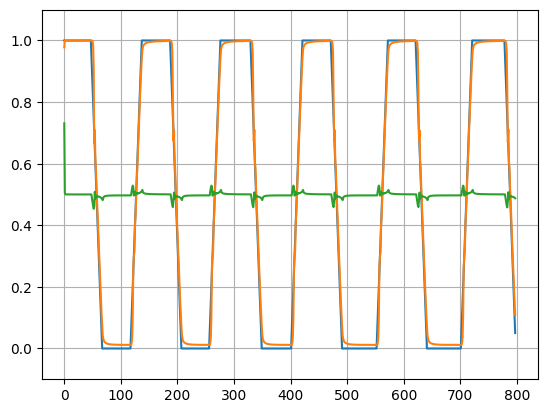

In [9]:
#print(best_individual.history)

for loop_list in best_individual.history:
    target_list = [d['target'] for d in loop_list]
    output_list = [d['output'][0] for d in loop_list]
    input_list = [d['input'] for d in loop_list]
    xlabel = [n for n in range(len(input_list))]
    #print(target_list)
    #print(output_list)
    plt.plot(xlabel, target_list)
    plt.plot(xlabel, output_list)
    plt.plot(xlabel, input_list)
    plt.ylim(-0.1,1.1)
    plt.grid()
    plt.show()